In [63]:
# import sys
# sys.path.append('.')

In [64]:
from utils import dump_jsonl, load_jsonl, CLOSENESS_LABELS, AUTHORITY_LABELS
import pandas as pd
import numpy as np

In [65]:
from collections import defaultdict

# ordinal_weights
def get_weights(categories):
    weights = defaultdict(dict)
    if len(categories)==3:
        mat = [[1.00, 0.67, 0.00], 
               [0.67, 1.00, 0.67], 
               [0.00, 0.67, 1.00]]
    elif len(categories)==4:
        mat = [[1.00, 0.83, 0.50, 0.00], 
               [0.83, 1.00, 0.83, 0.50], 
               [0.50, 0.83, 1.00, 0.83], 
               [0.00, 0.50, 0.83, 1.00]]
    elif len(categories)==5:
        mat = [[1, 0.9, 0.7, 0.4, 0.0], 
               [0.9, 1, 0.9, 0.7, 0.4], 
               [0.7, 0.9, 1, 0.9, 0.7], 
               [0.4, 0.7, 0.9, 1, 0.9],
               [0.0, 0.4, 0.7, 0.9, 1]]
    else:
        # Lazy to implement in case of len(categories) > 5
        raise Exception("No Implementation")
        
    for i, l in enumerate(categories): 
        for j, k in enumerate(categories): 
            weights[l][k] = mat[i][j]
    return weights

    
def cal_agreement(df1, df2, column, categories, cat_column):
    merged = pd.merge(df1, df2, on=column)
#     assert(len(df1)==len(merged))
    merged = merged.dropna()    
    cnt_matrix = defaultdict(dict)
    acc_matrix = defaultdict(dict)
    
    for l in categories: 
        for k in categories: 
            d = merged
            d = d[d[f"{cat_column}_x"]==k]
            d = d[d[f"{cat_column}_y"]==l]
            cnt_matrix[l][k] = len(d)
    
    for l in categories: 
        d = merged
        d = d[d[f"{cat_column}_x"]==l]
        acc_matrix["x"][l] = len(d)
        
        d = merged
        d = d[d[f"{cat_column}_y"]==l]
        acc_matrix["y"][l] = len(d)
    
    weights = get_weights(categories)
    
    N = len(merged)
    Pa = 0
    for l in categories: 
        for k in categories: 
            Pa += weights[l][k]*cnt_matrix[l][k]/N
    
    Pe = 0
    for l in categories: 
        for k in categories: 
            Pe += weights[l][k]*(acc_matrix["x"][l]/N)*(acc_matrix["y"][k]/N)
    
    if Pe==1:
        raise Exception("Divide by zero")
    
    kappa = (Pa-Pe)/(1-Pe)
    return kappa


## Task1

In [66]:
data = load_jsonl("./Task1/annotated_conersations.jsonl")

Loaded 1234 records from ./Task1/annotated_conersations.jsonl


In [67]:
data = pd.DataFrame(data)

In [68]:
# data = data[~pd.isna(data["relationship"])]

In [71]:
import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib.patches import Patch

sns.set()

def bar_plot(labels, values, figname=None, as_percentage=True):
    plt.rcParams.update({'font.size': 20})
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    
    if as_percentage:
        norm = sum(values)
        values = [v*100/norm for v in values]
        bar_labels = [f"{v:.2f}%" for v in values]
        plt.ylim([0, 100])
    else:
        bar_labels = [f"{v:.2f}" for v in values]
    
    x = np.arange(len(values))  # the label locations
    width = 0.75  # the width of the bars
    multiplier = 0

    rects = ax.bar(x, values, width, label=labels, color=sns.color_palette())
    
    barlabels = ax.bar_label(rects, padding=3)
    for bl, l in zip(barlabels, bar_labels):
        bl.set_font_properties({'size': 20})
        bl.set_text(l)
    
    cmap = dict(zip(label2newlabel(labels), sns.color_palette()))
    patches = [Patch(color=v, label=k) for k, v in cmap.items()]

    # add the legend
    plt.legend(handles=patches, loc='upper left', prop={'size': 15})
    ax.set_xticks(x, [])
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=15)

    if figname is not None:
        plt.savefig(f'{figname}.png', bbox_inches='tight', dpi=150)
        plt.savefig(f'{figname}.pdf', bbox_inches='tight', dpi=150)
    plt.show()
    


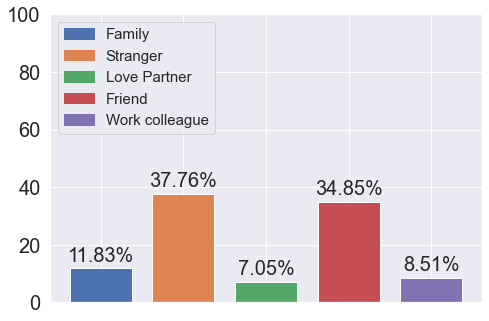

In [72]:
rel_maps = {
    'คนในครอบครัว (Family)': 'Family',
    'คนไม่รู้จัก (Stranger)': 'Stranger',
    'คู่รัก (Love Partner)': 'Love Partner',
    'เพื่อน (Friend)': 'Friend',
    'เพื่อนร่วมงาน (Work colleague)': 'Work colleague',
}

cnt = data.groupby("relationship").count()
labels = [rel_maps[rel] for rel in cnt.index]
values = cnt["topic"].values*100/len(data)
bar_plot(labels, values, figname="Figures/task1-relationship")

In [73]:
labelmap = {
    '1. Close': "1. Close", 
    '2. Know each other': "2. Acquainted", 
    "3. Don't know each other": "3. Unfamiliar",
    
    
    '0. Very respect': "0. Highly Respectful", 
    '1. Respect': "1. Respectful", 
    '2. Normal': "2. Normal", 
    '3. Not respect': "3. Disrespectful"
}

def label2newlabel(label):
    if type(label) is list or type(label) is np.ndarray:
        return [labelmap[l] if l in labelmap else l for l in label ]
    
    if label in labelmap:
        return labelmap[label]
    return label

In [74]:
label2newlabel(data.authority.unique())

['1. Respectful',
 '0. Highly Respectful',
 '2. Normal',
 None,
 '3. Disrespectful']

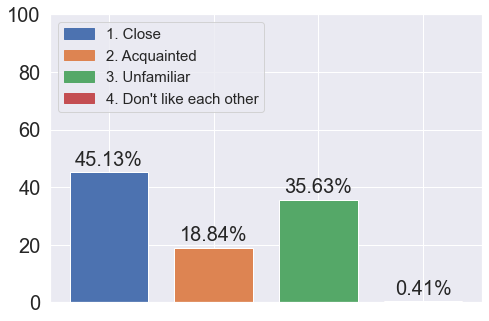

In [75]:
cnt = data.groupby("closeness").count()
labels = CLOSENESS_LABELS
values = [cnt["topic"][c] for c in labels]
bar_plot(labels, values, figname="Figures/task1-close")

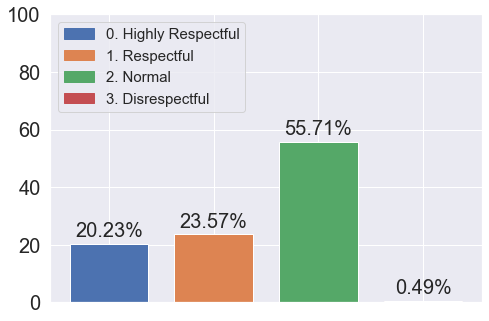

In [76]:
cnt = data.groupby("authority").count()
labels = AUTHORITY_LABELS
values = [cnt["topic"][c] for c in labels]
bar_plot(labels, values, figname="Figures/task1-auth")

#### Closeness/Respect Correlation

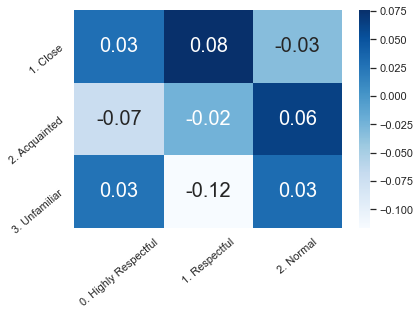

In [78]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_heatmap(data, xlabels, ylabels):

    mat = []
    
    for clos in ylabels:
        row = []
        for auth in xlabels:
            d = data
            d = d[d["closeness"]==clos]
            d = d[d["authority"]==auth]
            p_clos_auth = len(d)/len(data)
            if p_clos_auth==0:
                p_clos_auth = 0.1/len(data)
                
#             row.append(p_clos_auth)
            
            p_clos = len(data[data["closeness"]==clos])/len(data)
            p_auth = len(data[data["authority"]==auth])/len(data)
            pmi = np.log2(p_clos_auth/(p_clos*p_auth))
            row.append(pmi)
        
        mat.append(row)

    ax = sns.heatmap(mat, annot=True, fmt=".2f", cmap="Blues")
    ax.set(xlabel="", ylabel="")
    ax.yaxis.set_ticklabels(label2newlabel(ylabels), rotation=40)
    ax.xaxis.set_ticklabels(label2newlabel(xlabels), rotation=40)
    

AUTHORITY_LABELS1 = ['0. Very respect', '1. Respect', '2. Normal']
CLOSENESS_LABELS1 = ['1. Close', '2. Know each other', "3. Don't know each other"]


plot_heatmap(data, AUTHORITY_LABELS1, CLOSENESS_LABELS1)

In [79]:
from sklearn.metrics import mutual_info_score, adjusted_mutual_info_score

In [80]:
d = data.dropna()
MI = adjusted_mutual_info_score(d["closeness"], d["authority"])
MI

0.01550967924866547

Values close to zero indicate two label assignments that are largely independent, while values close to one indicate significant agreement.

## Task 2

In [81]:
data = load_jsonl("./Task2/annotated/annotated.jsonl")

Loaded 2486 records from ./Task2/annotated/annotated.jsonl


In [82]:
data = pd.DataFrame(data)

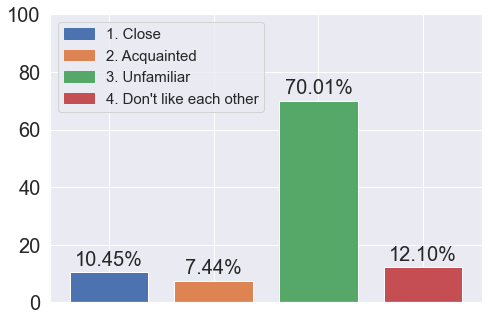

In [83]:
cnt = data.groupby("closeness").count()
labels = CLOSENESS_LABELS
values = [cnt["text"][c] for c in labels]
bar_plot(labels, values, figname="Figures/task2-clos")

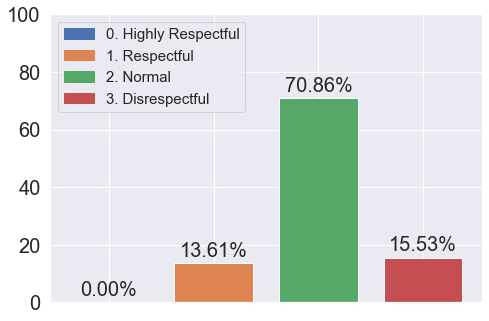

In [84]:
cnt = data.groupby("authority").count()
labels = AUTHORITY_LABELS
values = [cnt["text"][c] if c in cnt["text"] else 0 for c in labels ]
bar_plot(labels, values, figname="Figures/task2-auth")

In [85]:
from sklearn.metrics import mutual_info_score, adjusted_mutual_info_score
data = data[~pd.isna(data["closeness"])]
data = data[~pd.isna(data["authority"])]

d = data
MI = adjusted_mutual_info_score(d["closeness"], d["authority"])
MI

0.23693749738451444

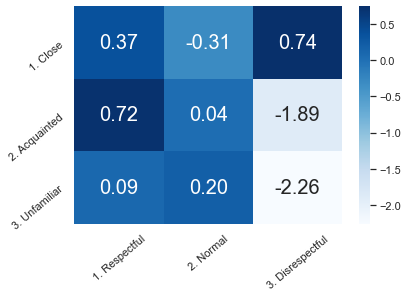

In [86]:
AUTHORITY_LABELS1 = ['1. Respect', '2. Normal', '3. Not respect']
CLOSENESS_LABELS1 = ['1. Close', '2. Know each other', "3. Don't know each other"]


plot_heatmap(data, AUTHORITY_LABELS1, CLOSENESS_LABELS1)


In [87]:
data["_id"] = data.index

In [88]:
avgiaa = []
for c1, c2 in [("closeness_1", "closeness_2"), ("closeness_1", "closeness_3"), ("closeness_3", "closeness_2")]:
    data1 = data.copy()
    data2 = data.copy()
    data1["closeness"] = data1[c1]
    data2["closeness"] = data1[c2]

    iaa = cal_agreement(data1, data2, column="_id", categories=CLOSENESS_LABELS, cat_column="closeness")
    print(iaa)
    avgiaa.append(iaa)

np.mean(avgiaa)

0.5409077209645027
0.4559701330268247
0.4475387372046099


0.48147219706531247

In [89]:
avgiaa = []
for c1, c2 in [("authority_1", "authority_2"), ("authority_1", "authority_3"), ("authority_3", "authority_2")]:
    data1 = data.copy()
    data2 = data.copy()
    data1["authority"] = data1[c1]
    data2["authority"] = data1[c2]

    iaa = cal_agreement(data1, data2, column="_id", categories=AUTHORITY_LABELS, cat_column="authority")
    print(iaa)
    avgiaa.append(iaa)

np.mean(avgiaa)

0.6403212825231619
0.5382152201062983
0.6617571523524692


0.6134312183273097

## Task 3

In [90]:
data = load_jsonl("./Task3/annotated/annotated.jsonl")
data = pd.DataFrame(data)

Loaded 1221 records from ./Task3/annotated/annotated.jsonl


In [91]:
data

,topic,room_id,messages,relationship,closeness,authority,closeness_1,closeness_2,closeness_3,authority_1,authority_2,authority_3
0,ชีวิตครอบครัว,52,"[{'user_id': 39, 'text': 'ดีๆวาย', 'date_creat...",เพื่อน (Friend),1. Close,2. Normal,1. Close,1. Close,2. Know each other,2. Normal,2. Normal,2. Normal
1,ภาพยนตร์,54,"[{'user_id': 41, 'text': 'วันนี้เรามาพูดถึงเรื...",คนในครอบครัว (Family),2. Know each other,2. Normal,2. Know each other,2. Know each other,2. Know each other,2. Normal,2. Normal,2. Normal
2,ซื้อรถ,55,"[{'user_id': 43, 'text': 'เธอ', 'date_created'...",คู่รัก (Love Partner),2. Know each other,2. Normal,1. Close,1. Close,2. Know each other,2. Normal,2. Normal,2. Normal
3,สัตว์เลี้ยง,56,"[{'user_id': 44, 'text': 'มึง', 'date_created'...",เพื่อน (Friend),1. Close,3. Not respect,1. Close,1. Close,1. Close,3. Not respect,3. Not respect,2. Normal
4,สัตว์เลี้ยง,58,"[{'user_id': 47, 'text': 'อ้วน', 'date_created...",คู่รัก (Love Partner),1. Close,2. Normal,1. Close,1. Close,2. Know each other,3. Not respect,2. Normal,2. Normal
...,...,...,...,...,...,...,...,...,...,...,...,...
1216,สภาพอากาศ,4792,"[{'user_id': 5021, 'text': 'Hi', 'date_created...",คนไม่รู้จัก (Stranger),2. Know each other,2. Normal,2. Know each other,2. Know each other,2. Know each other,2. Normal,2. Normal,2. Normal
1217,ซื้อรถ,4799,"[{'user_id': 5025, 'text': 'ทักๆ', 'date_creat...",เพื่อน (Friend),1. Close,2. Normal,1. Close,1. Close,2. Know each other,2. Normal,2. Normal,2. Normal
1218,หนังสือและวรรณคดี,4819,"[{'user_id': 5031, 'text': 'สวัสดีตอนเช้าค่ะ',...",เพื่อนร่วมงาน (Work colleague),2. Know each other,2. Normal,1. Close,2. Know each other,2. Know each other,2. Normal,2. Normal,2. Normal
1219,การทำสวน,4820,"[{'user_id': 5033, 'text': 'สวัสดีค่ะ', 'date_...",คนไม่รู้จัก (Stranger),2. Know each other,2. Normal,1. Close,2. Know each other,2. Know each other,2. Normal,2. Normal,2. Normal


In [92]:
# data

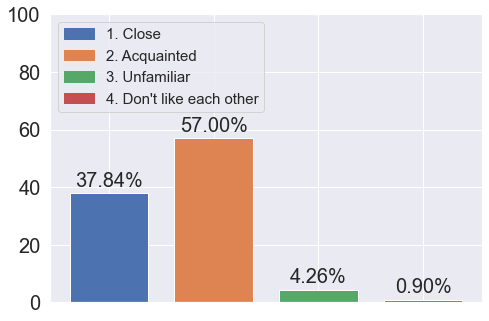

In [93]:
cnt = data.groupby("closeness").count()
labels = CLOSENESS_LABELS
values = [cnt["messages"][c] for c in labels]
bar_plot(labels, values, figname="Figures/task3-clos")

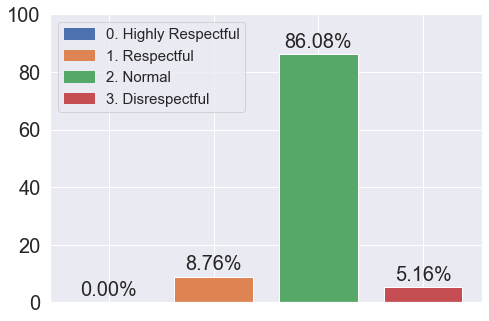

In [94]:
cnt = data.groupby("authority").count()
labels = AUTHORITY_LABELS
values = [cnt["messages"][c] if c in cnt["messages"] else 0 for c in labels ]
bar_plot(labels, values, figname="Figures/task3-auth")

In [95]:
from sklearn.metrics import mutual_info_score, adjusted_mutual_info_score
data = data[~pd.isna(data["closeness"])]
data = data[~pd.isna(data["authority"])]

d = data
MI = adjusted_mutual_info_score(d["closeness"], d["authority"])
MI

0.13603079920760636

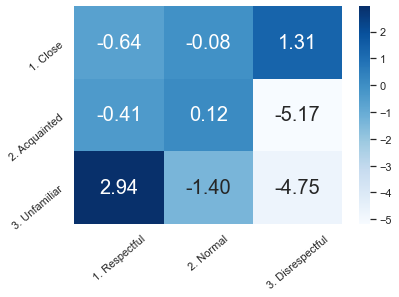

In [96]:
AUTHORITY_LABELS1 = ['1. Respect', '2. Normal', '3. Not respect']
CLOSENESS_LABELS1 = ['1. Close', '2. Know each other', "3. Don't know each other"]


plot_heatmap(data, AUTHORITY_LABELS1, CLOSENESS_LABELS1)


In [97]:
# AUTHORITY_LABELS1 = ['1. Respect', '2. Normal', '3. Not respect']
# CLOSENESS_LABELS1 = ['1. Close', '2. Know each other', "3. Don't know each other"]


# plot_heatmap(data, AUTHORITY_LABELS1, CLOSENESS_LABELS1)


In [98]:
data["_id"] = data.index

In [99]:
avgiaa = []
for c1, c2 in [("closeness_1", "closeness_2"), ("closeness_1", "closeness_3"), ("closeness_3", "closeness_2")]:
    data1 = data.copy()
    data2 = data.copy()
    data1["closeness"] = data1[c1]
    data2["closeness"] = data1[c2]

    iaa = cal_agreement(data1, data2, column="_id", categories=CLOSENESS_LABELS, cat_column="closeness")
    print(iaa)
    avgiaa.append(iaa)

np.mean(avgiaa)

0.6941146976706173
0.2508945033095894
0.37738701802146224


0.440798739667223

In [100]:
avgiaa = []
for c1, c2 in [("authority_1", "authority_2"), ("authority_1", "authority_3"), ("authority_3", "authority_2")]:
    data1 = data.copy()
    data2 = data.copy()
    data1["authority"] = data1[c1]
    data2["authority"] = data1[c2]

    iaa = cal_agreement(data1, data2, column="_id", categories=AUTHORITY_LABELS, cat_column="authority")
    print(iaa)
    avgiaa.append(iaa)

np.mean(avgiaa)

0.3686328681427825
0.1267859951536802
0.42206546561267505


0.30582810963637924

In [101]:
len(data)

1221

#### Agreement between self-reported and percieved

In [102]:
data1 = load_jsonl("./Task1/annotated_conersations.jsonl")
data1 = pd.DataFrame(data1)

Loaded 1234 records from ./Task1/annotated_conersations.jsonl


In [103]:
data3 = load_jsonl("./Task3/annotated/annotated.jsonl")
data3 = pd.DataFrame(data3)

Loaded 1221 records from ./Task3/annotated/annotated.jsonl


In [104]:
from collections import defaultdict

# ordinal_weights
def get_acc_weights(categories):
    weights = defaultdict(dict)
    if len(categories)==3:
        # mat = [[1.00, 0.67, 0.00], 
        #        [0.67, 1.00, 0.67], 
        #        [0.00, 0.67, 1.00]]
        mat = [[1.00, 0.5, 0.00], 
               [0.5, 1.00, 0.5], 
               [0.00, 0.5, 1.00]]
    elif len(categories)==4:
        # mat = [[1.00, 0.83, 0.50, 0.00], 
        #        [0.83, 1.00, 0.83, 0.50], 
        #        [0.50, 0.83, 1.00, 0.83], 
        #        [0.00, 0.50, 0.83, 1.00]]
        mat = [[1.00, 0.5, 0.0, 0.00], 
               [0.5, 1.00, 0.5, 0.0], 
               [0.0, 0.5, 1.00, 0.5], 
               [0.00, 0.0, 0.5, 1.00]]
    else:
        # Lazy to implement in case of len(categories) > 5
        raise Exception("No Implementation")
        
    for i, l in enumerate(categories): 
        for j, k in enumerate(categories): 
            weights[l][k] = mat[i][j]
    return weights

from sklearn.metrics import f1_score, accuracy_score

def cal_accuracy(df1, df2, column, categories, cat_column):
    d = pd.merge(df1, df2, on=column)[[f"{cat_column}_x", f"{cat_column}_y"]].dropna()
    
    d1 = d[f"{cat_column}_x"]
    d2 = d[f"{cat_column}_y"]

    return {
        "f1": f1_score(d1, d2, labels=categories, average="weighted"),
        "accuracy": accuracy_score(d1, d2),
    }

In [105]:
iaa = cal_agreement(data1, data3, column="room_id", categories=CLOSENESS_LABELS, cat_column="closeness")
iaa

0.43320958880903765

In [106]:
iaa = cal_agreement(data1, data3, column="room_id", categories=AUTHORITY_LABELS, cat_column="authority")
iaa

0.05800680747367774

In [107]:
# cal_accuracy(data1, data3, column="room_id", categories=CLOSENESS_LABELS, cat_column="closeness")

In [108]:
cal_accuracy(data1, data3, column="room_id", categories=AUTHORITY_LABELS, cat_column="authority")

{'f1': 0.4122425887840673, 'accuracy': 0.5061830173124485}

In [109]:
cal_accuracy(data1, data3, column="room_id", categories=CLOSENESS_LABELS, cat_column="closeness")

{'f1': 0.45763095874566695, 'accuracy': 0.47174447174447176}

In [110]:
cal_accuracy(data1, data3, column="room_id", categories=AUTHORITY_LABELS, cat_column="authority")

{'f1': 0.4122425887840673, 'accuracy': 0.5061830173124485}